In [1]:
import pandas as pd

nifty50_df = pd.read_csv('nifty50.csv')

replaced_tickers = pd.read_csv('nifty50_changes.csv')
stock_changes = pd.read_csv('nifty50_changes.csv')
stock_changes['start_date'] = pd.to_datetime(stock_changes['start_date'])
stock_changes['end_date'] = pd.to_datetime(stock_changes['end_date'])

tickers = [f"NSE:{t}-EQ" for t in set(nifty50_df['Symbol'].tolist())] + stock_changes.symbol.tolist()

In [2]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Error fetching data for NSE:HDFC-EQ: 'candles'


Loading 1Dmin data: 100%|██████████| 62/62 [00:00<00:00, 373.28it/s]


In [3]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

In [4]:
import talib as ta

df.Date = pd.to_datetime(df.Date)
# Calculate RSI per stock
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA20_Perc_Distance'] = (df['Close'] - df['SMA20']) / df['SMA20'] * 100

df['Entry_Price'] = df.groupby('Stock')['Open'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)

# df = df[df.Date >= '2020-01-01 05:30:00']

In [5]:
signals = (
    df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))
      .sort_values(['Date', 'SMA20_Perc_Distance']).reset_index(drop=True).dropna(subset=['Entry_Price'])
)

/var/folders/rw/xc9yc4151v3_3lcv8h2n7pxr0000gn/T/ipykernel_53773/960733863.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))


In [6]:
from dataclasses import asdict
from tqdm.notebook import tqdm
from lib import PositionManager, Bank

rebalance_perc = 100
max_holding_period = 5000  # days
max_num_of_avgs = 3
initial_capital = 1000000
leverage = 1
tp_perc = 8
sl_perc = 100
max_positions_num = 25
mtf_rate_daily = 0.0192 / 100  # Margin funding rate (per day)


def select_stock_for_entry(pm, signals: pd.DataFrame):
    selected_stocks = []
    for _, signal in signals.iterrows():
        if pm.get_position(signal.Stock) is None:
            if signal.Stock in stock_changes.symbol.tolist():
                stock = stock_changes[stock_changes.symbol == signal.Stock]
                if signal.Date >= stock.start_date.values[0] and signal.Date <= stock.end_date.values[0]:
                    selected_stocks.append(signal)
            else:
                selected_stocks.append(signal)
    return selected_stocks[0] if len(selected_stocks) > 0 else None


def init_new_position(k, v, pm: PositionManager):
    selected_stock = select_stock_for_entry(pm, signals[signals.Date == k])
    if selected_stock is None:
        return None

    capital = pm.bank.total_capital()/max_positions_num
    return pm.new_position(selected_stock.Stock, selected_stock.Entry_Time, selected_stock.Entry_Price, capital)    

def avg_out_active_positions(k, v, pm: PositionManager):
    global max_num_of_avgs
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
        .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Close', 'Entry_Time', 'Entry_Price']])
    )
    apdf['perc_change'] = (apdf.Close - apdf.last_entry_price)/apdf.last_entry_price * 100
    rebalance_stocks = apdf[apdf.perc_change <= -rebalance_perc].sort_values('perc_change')
    if len(rebalance_stocks) == 0:
        return

    for k, stock in rebalance_stocks.iterrows():
        position = pm.get_position(stock.name)
        if len(position.trades) == max_num_of_avgs:
            continue

        pm.add_trade_to_position(stock.name, stock.Entry_Time, stock.Entry_Price)
        break

def book_profit(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['High', 'Close', 'Date']])
    )
    apdf = apdf[apdf.High >= apdf.tp]
    apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    for k, selected_stock in selected_stocks.iterrows():
        pm.close_position(selected_stock.name, selected_stock.Date, selected_stock.tp)


def exit_long_running_positions(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Date', 'Close']])
    )
    apdf['holding_period'] = (k - apdf.entry_time).dt.days
    long_running_positions = apdf[apdf.holding_period >= max_holding_period]
    
    for stock, lr_position in long_running_positions.iterrows():
        pm.close_position(stock, lr_position.Date, lr_position.Close)
        
def book_loss(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Low', 'Close', 'Date']])
    )
    apdf = apdf[apdf.Low <= apdf.sl]
    apdf['perc_change'] = (apdf.avg_entry_price - apdf.Close)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    for selected_stock in selected_stocks.itertuples():
        pm.close_position(selected_stock.Index, selected_stock.Date, selected_stock.sl)
        
def exit_if_removed_from_index(k, v, pm):
    if not pm.has_active_positions():
        return

    for p in pm.get_active_positions():
        if p.stock not in stock_changes.symbol.tolist():
            continue
        stock = stock_changes[stock_changes.symbol == p.stock]
        if k > stock.end_date.values[0]:
            pm.close_position(p.stock, k, v[v.Stock == p.stock].Close.values[0])

def exit_position(k, v, pm):
    # book_loss(k, v, pm)
    exit_if_removed_from_index(k, v, pm)
    exit_long_running_positions(k, v, pm)

def backtest(pm):
    pb = tqdm(total=len(df.Date.unique()))
    for k, v in df.groupby('Date'):
        book_profit(k, v, pm)
        
        position = init_new_position(k, v, pm)
        if position is None:
            avg_out_active_positions(k, v, pm)

        exit_position(k, v, pm)
        pb.update(1)
    pb.close()


def main():
    bank = Bank(initial_capital)
    pm = PositionManager(bank, tp_perc=tp_perc, sl_perc=sl_perc, leverage=leverage, mtf_rate_daily=mtf_rate_daily)
    backtest(pm)
    return bank, pm

bank, pm = main()

  0%|          | 0/2642 [00:00<?, ?it/s]

capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not available - 0.0
capital not availabl

In [ ]:
trades = pm.get_trades()

                       Metric                     Value
0                      Period  2015-01-30 to 2025-08-18
1            Starting capital                1000000.00
2               Final capital                4251648.48
3                Total Trades                       531
4                     Winners                       523
5                      Losers                         8
6               Profit factor                     12.21
7       Active Position Count                        28
8   Max holding period (days)                     3,255
9   Avg holding period (days)                       170
10               Win Rate (%)                     98.49
11               Total Profit              3,251,648.48
12            Total Brokerage                    320.00
13                  Total Tax                  18689.81
14                  Total MTF                       N/A
15                   CAGR (%)                     14.71
16           Max Drawdown (%)                   

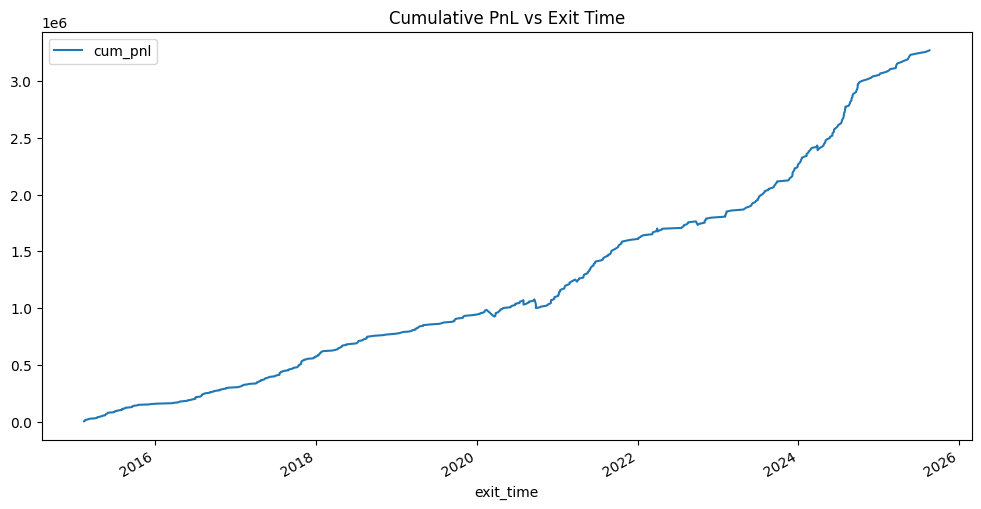

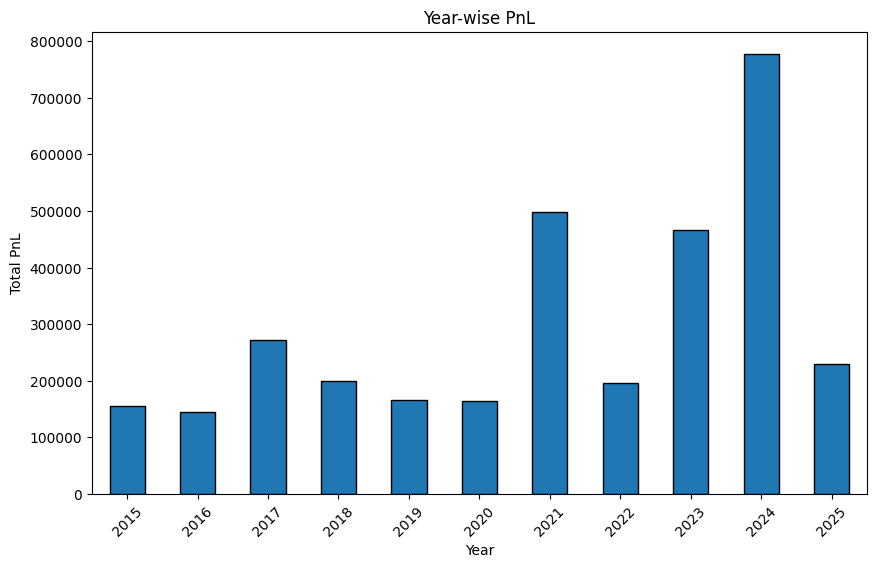

In [8]:
from lib import print_tearsheet, show_equity_curve

print_tearsheet(initial_capital=initial_capital, pm=pm, trades=trades)
show_equity_curve(trades)

In [10]:
losses = [c for c in pm.closed_positions if c.pnl < 0]
losses_df = pd.DataFrame([asdict(p) for p in losses]).sort_values(['entry_time']).reset_index(drop=True)
losses_df.to_csv('losses.csv', index=False)

Text(0, 0.5, 'Frequency')

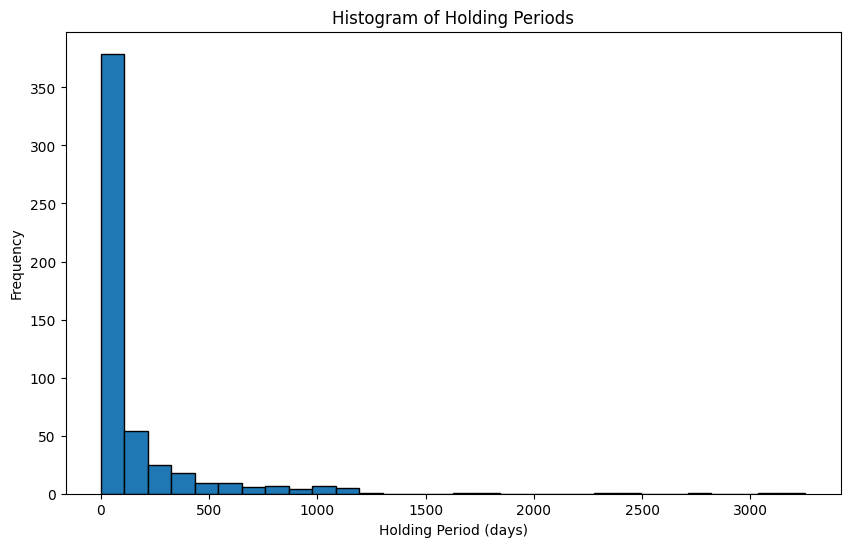

In [11]:
trades['holding_period'] = (trades['exit_time'] - trades['entry_time']).dt.days

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
trades['holding_period'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Holding Periods')
plt.xlabel('Holding Period (days)')
plt.ylabel('Frequency')